In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

In [2]:
# Let's load the model 
device = 'cuda:4'
model_name = 'microsoft/Phi-3-mini-4k-instruct'

# Load Phi model 
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    device_map=device, 
    torch_dtype="auto", 
    trust_remote_code=True, 
)

tokenizer = AutoTokenizer.from_pretrained(model_name)

model

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Phi3ForCausalLM(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072, padding_idx=32000)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x Phi3DecoderLayer(
        (self_attn): Phi3Attention(
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (qkv_proj): Linear(in_features=3072, out_features=9216, bias=False)
          (rotary_emb): Phi3RotaryEmbedding()
        )
        (mlp): Phi3MLP(
          (gate_up_proj): Linear(in_features=3072, out_features=16384, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (activation_fn): SiLU()
        )
        (input_layernorm): Phi3RMSNorm()
        (resid_attn_dropout): Dropout(p=0.0, inplace=False)
        (resid_mlp_dropout): Dropout(p=0.0, inplace=False)
        (post_attention_layernorm): Phi3RMSNorm()
      )
    )
    (norm): Phi3RMSNorm()
  )
  (lm_head): Linear(in_features=3072, out_features=3206

In [84]:
text = "1:sunshine, 2:apple, 3:koala, 2:apple, 1:sunshine, 3:koala, 1:"
text_tokenized = tokenizer.encode(text, return_tensors='pt').to(device)
output = model.generate(text_tokenized, num_beams=4, do_sample=True, max_new_tokens = 3)
text_decoded = tokenizer.decode(output[0])
print(text_decoded)

1:sunshine, 2:apple, 3:koala, 2:apple, 1:sunshine, 3:koala, 1:sunshine


In [85]:
def decode_token_with_logitlens(model, device, tokenizer, input, tokens_to_gen=None): 
    '''
    outputs a dictionary with {'decoded_tokens': [num_layers, seq_len], 'decoded_logits': [num_layers, seq_len]}
    '''
    inputs = tokenizer(input, return_tensors="pt").to(device)
    
    text = tokenizer.decode(inputs['input_ids'][0])
    # run the loop to generate new tokens after input, append to input and decode 
    if tokens_to_gen != None: 
        # generate new tokens all at once; then append them to input, then logitlens them all
        output = model.generate(
            inputs['input_ids'],
            do_sample=True,
            top_p=0.95,
            temperature=0.001,
            top_k=0,
            max_new_tokens=tokens_to_gen,
            )
        new_token = tokenizer.decode(output[0][-tokens_to_gen:])
        text += new_token
        inputs = tokenizer(text, return_tensors="pt").to(device)
    text_tokens = [tokenizer.decode(id) for id in inputs['input_ids'][0]]
    
    # apply decoder lens
    classifier_head = model.lm_head # Linear(in_features=3072, out_features=32064, bias=False)

    hidden_states = model(**inputs, output_hidden_states = True).hidden_states
    decoded_intermediate_token = {}
    decoded_intermediate_logit = {}
    with torch.no_grad():
        for layer_id in range(len(hidden_states)): 
            hidden_state = hidden_states[layer_id]
            decoded_value = classifier_head(hidden_state) # [batch, seq_len, vocab_size]
            # get probabilities
            decoded_values = torch.nn.functional.softmax(decoded_value, dim=-1)
            # take max element
            argmax = torch.argmax(decoded_values, dim=-1)[0] # select first element in batch
            # decode all tokens
            decoded_token = [tokenizer.decode(el) for el in argmax]
            decoded_logit = [decoded_values[0, it, argmax[it]].item() for it in range(len(argmax))] # list of layers, per layer the sequence_length
            decoded_intermediate_token[layer_id] = decoded_token
            decoded_intermediate_logit[layer_id] = decoded_logit

    tokens = list(decoded_intermediate_token.values()) # [num_layers, seq_len]
    logits = list(decoded_intermediate_logit.values()) # [num_layers, seq_len]
    return {'text_tokens':text_tokens, 'decoded_tokens': tokens, 'decoded_logits': logits}

In [90]:
# let's test patch decode 
dict_output = decode_token_with_logitlens(model, device, tokenizer, text, tokens_to_gen=3)
decoded_tokens = dict_output['decoded_tokens']
decoded_logits = dict_output['decoded_logits']
text_tokens = dict_output['text_tokens']
print(len(text_tokens), text_tokens)

42 ['', '1', ':', 'sun', 'sh', 'ine', ',', '', '2', ':', 'apple', ',', '', '3', ':', 'ko', 'ala', ',', '', '2', ':', 'apple', ',', '', '1', ':', 'sun', 'sh', 'ine', ',', '', '3', ':', 'ko', 'ala', ',', '', '1', ':', 'sun', 'sh', 'ine']


In [87]:
for element in range(len(decoded_tokens)):
    print(decoded_tokens[element])

['raph', 'mí', 'Screen', 'ho', 'elter', 'Hill', 'sondern', 'raph', 'nd', 'Screen', 'okat', 'sondern', 'raph', 'rd', 'Screen', 'ong', 'zen', 'sondern', 'raph', 'nd', 'Screen', 'okat', 'sondern', 'raph', 'mí', 'Screen', 'ho', 'elter', 'Hill', 'sondern', 'raph', 'rd', 'Screen', 'ong', 'zen', 'sondern', 'raph', 'mí', 'Screen', 'ho', 'elter', 'Hill', 'sondern', 'raph', 'nd', 'Screen', 'okat', 'sondern', 'raph']
['☺', 'míst', 'míst', 'Err', '☺', 'míst', 'míst', '☺', '♯', 'míst', 'Ê', 'míst', '☺', '♯', 'míst', '\ufeff', '⇔', 'míst', '☺', '♯', 'míst', 'Ê', 'míst', '☺', 'míst', 'míst', 'Err', 'míst', 'míst', 'míst', '☺', '♯', 'míst', '\ufeff', '⇔', 'míst', '☺', 'míst', 'míst', 'Err', 'míst', 'míst', 'míst', '☺', '♯', 'míst', 'Ê', 'míst', '☺']
['míst', 'míst', '\u2002', '‒', 'míst', '☺', 'míst', 'míst', 'míst', '\x97', '☺', 'míst', 'ltre', 'míst', '\x97', '\ufeff', 'míst', 'míst', 'ltre', 'míst', '\x97', '☺', 'míst', 'ltre', 'míst', '\x97', 'Vé', 'elter', '☺', 'míst', 'ltre', '♯', '\x97', '\ufef

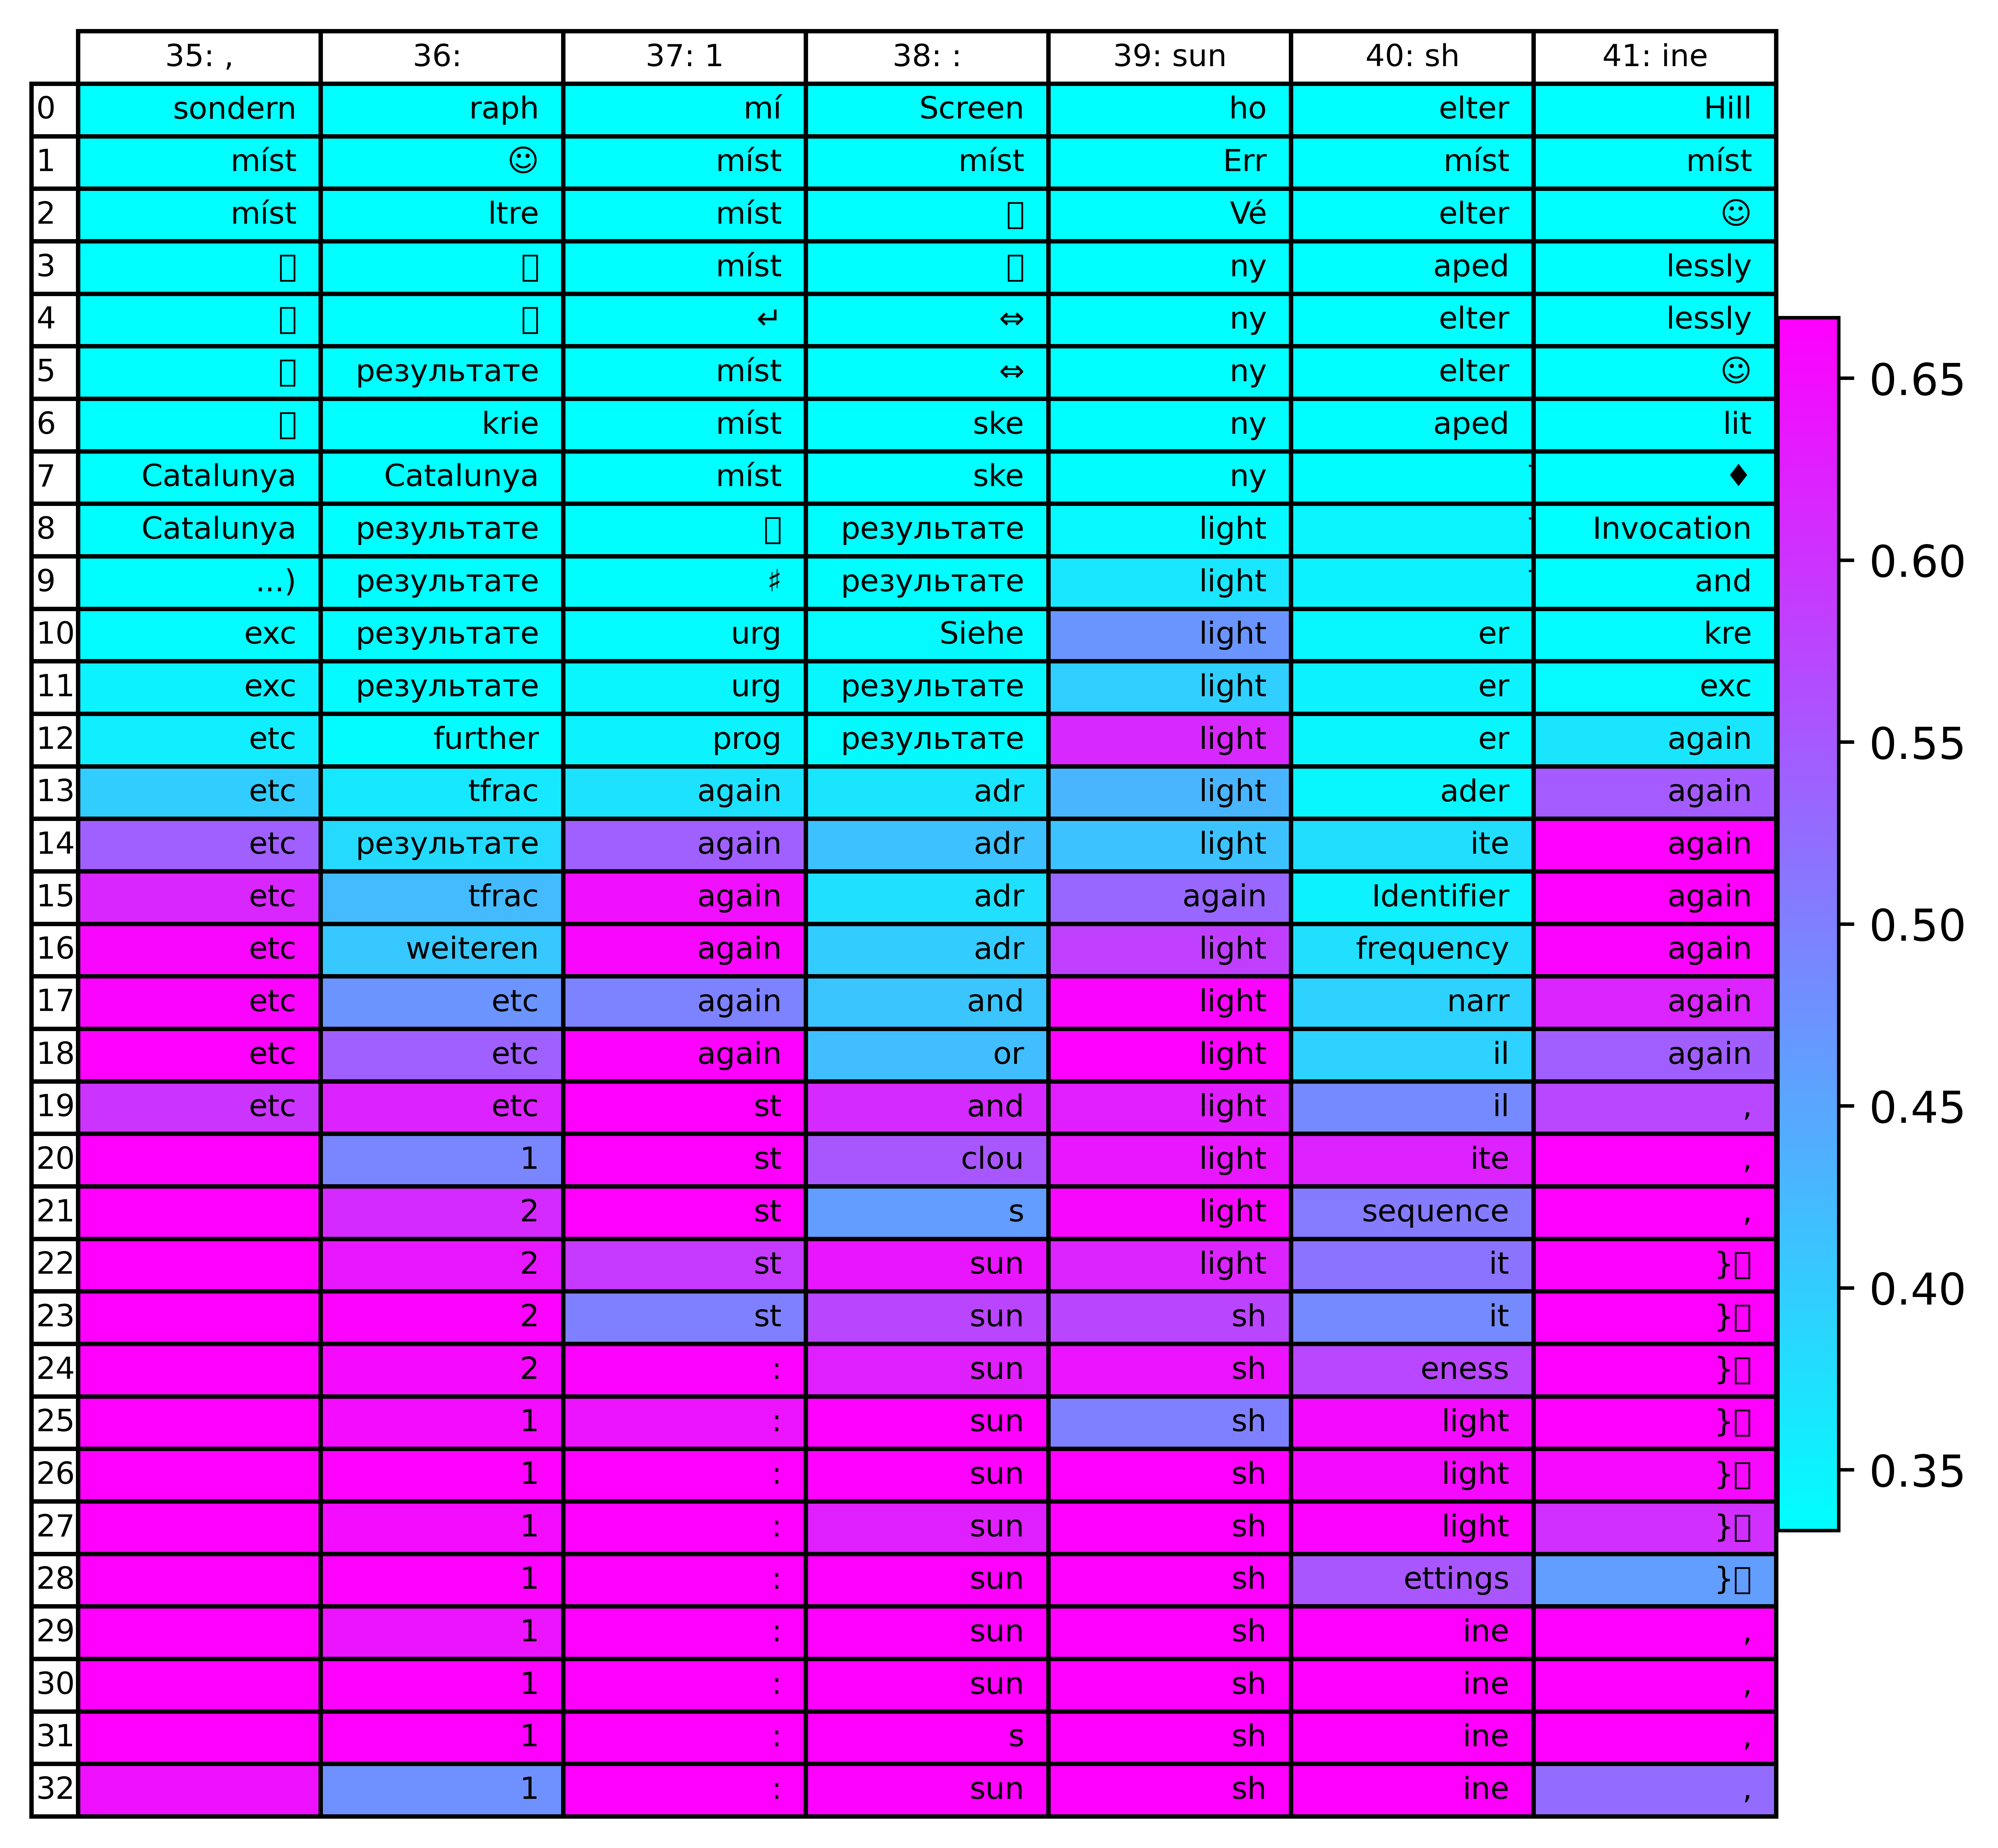

In [91]:
to_viz = (35,42)
tokens_viz = [tok[to_viz[0]:to_viz[1]] for tok in decoded_tokens] # [num_layers, tokens_to_viz]
logits_viz = np.array([log[to_viz[0]:to_viz[1]] for log in decoded_logits]) # [num_layers, tokens_to_viz]
a = [it for it in range(to_viz[0],to_viz[1])]
b = [tok for tok in text_tokens[to_viz[0]:to_viz[1]]]
col_labels = [str(a_)+': '+b_ for a_, b_ in zip(a, b)]
norm = plt.Normalize(logits_viz.min()-1, logits_viz.max()+1)
colours = plt.cm.cool(norm(logits_viz))
fig, ax = plt.subplots(figsize=(20,5), dpi=1000)
# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
img = plt.imshow(norm(logits_viz), cmap="cool")
plt.colorbar()
img.set_visible(False)
ax.table(cellText=tokens_viz, rowLabels=[lay for lay in range(len(decoded_tokens))], colLabels=col_labels, colWidths = [0.2]*logits_viz.shape[1], loc='center', cellColours=img.to_rgba(norm(logits_viz))) 
plt.show()